In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
import numpy as np

In [2]:
os.chdir('./dataset/')

In [3]:
plt.style.use('dark_background')
%pylab inline

TRAINING_MODE = False
NB_EPOCHS_MAX = 100

Populating the interactive namespace from numpy and matplotlib


In [4]:
def fast_display(*img2dlst):
    plt.figure(figsize=(16, 8))
    nbimg = len(img2dlst)
    cols = min(9, nbimg)
    rows = (nbimg // cols) + 1
    for ii, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, 1+ii)
        plt.imshow(img2d)
    plt.show()

In [5]:
def PrintSlices(img):
    sx, sy, sz, _ = img.shape
    fast_display(img[sx//2,:, :, 0], img[sy//2,:, :, 0], img[sz//2,:, :, 0], )

New patient :  subject-3-label.img
T1 : Coupes sagittale, coronale, axiale de subject-3-label.img


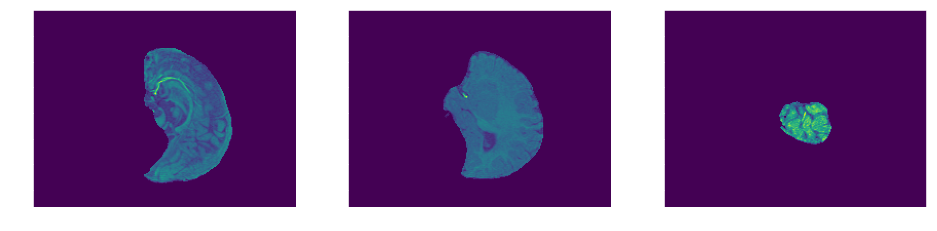

T2 : Coupes sagittale, coronale, axiale de subject-3-label.img


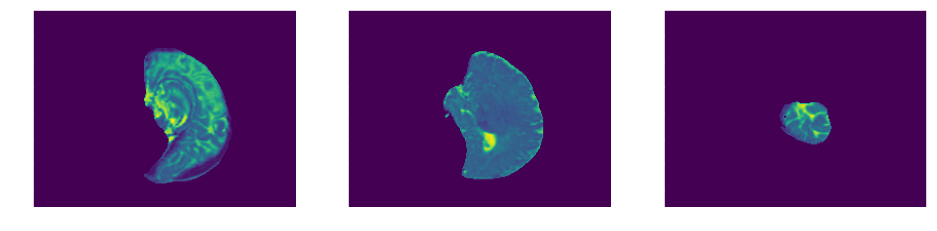

LABELS : Coupes sagittale, coronale, axiale de subject-3-label.img


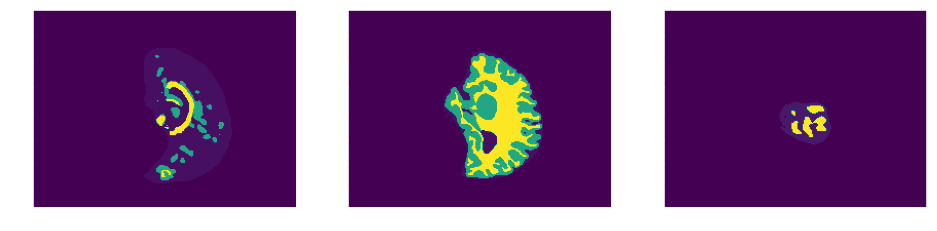

New patient :  subject-2-label.img
New patient :  subject-1-label.img
New patient :  subject-4-label.img
New patient :  subject-5-label.img
New patient :  subject-10-label.img
New patient :  subject-6-label.img
New patient :  subject-9-label.img
New patient :  subject-8-label.img
New patient :  subject-7-label.img


In [6]:
nb_patient = 0
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if "label" in filename and "hdr" not in filename:
            print("New patient : ", filename)
            
            nomT1 = filename[:-10] + "-T1.img"
            T1 = nib.load(nomT1).get_fdata()
            if nb_patient == 0:
                print("T1 : Coupes sagittale, coronale, axiale de", filename)
                PrintSlices(T1)
            
            nomT2 = filename[:-10] + "-T2.img"
            T2 = nib.load(nomT2).get_fdata()
            if nb_patient == 0:
                print("T2 : Coupes sagittale, coronale, axiale de", filename)
                PrintSlices(T2)
            
            labels = nib.load(filename).get_fdata()
            if nb_patient == 0:
                print("LABELS : Coupes sagittale, coronale, axiale de", filename)
                PrintSlices(labels)
            
            nb_patient += 1

In [7]:
def ComputeDice(X, Y):
    Xbin = X > 0
    Ybin = Y > 0
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    cardIntersec = np.sum(Xbin & Ybin)
    
    print("CardIntersec =", cardIntersec)
    print("CardX =", cardX)
    print("CardY =", cardY)
    
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec) / (cardX + cardY)
        print("Dice =", dice)
        return dice
    else:
        return 0

In [8]:
def Normalisation(img):
    mu = np.mean(img[img > 0])
    sigma = np.std(img[img > 0])
    return ((img - mu) / sigma)

In [9]:
print(nb_patient)

nb_patient_training = nb_patient * 0.6
nb_patient_validation = nb_patient * 0.2
nb_patient_test = nb_patient * 0.2

10


In [10]:
threashold_area = 100
nb_intersting_slices_training = 0
nb_intersting_slices_validation = 0
nb_patient = 0

for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if "label" in filename and "hdr" not in filename:
            if (nb_patient < nb_patient_training) or (nb_patient >= nb_patient_training and nb_patient < nb_patient_training + nb_patient_validation):
                print("PATIENT (training):", filename)
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= threashold_area:
                        if nb_patient < nb_patient_training:
                            nb_intersting_slices_training += 1
                        if nb_patient >= nb_patient_training and nb_patient < nb_patient_training + nb_patient_validation:
                            nb_intersting_slices_validation += 1
            nb_patient += 1
            
print("Number of intersting slices for training:", nb_intersting_slices_training)
print("Number of intersting slices for validation:", nb_intersting_slices_validation)

PATIENT (training): subject-3-label.img
PATIENT (training): subject-2-label.img
PATIENT (training): subject-1-label.img
PATIENT (training): subject-4-label.img
PATIENT (training): subject-5-label.img
PATIENT (training): subject-10-label.img
PATIENT (training): subject-6-label.img
PATIENT (training): subject-9-label.img
Number of intersting slices for training: 1536
Number of intersting slices for validation: 512


In [11]:
x_train = np.zeros((nb_intersting_slices_training, sx, sy, 2))
y_train = np.zeros((nb_intersting_slices_training, sx, sy, 1))

x_valid = np.zeros((nb_intersting_slices_validation, sx, sy, 2))
y_valid = np.zeros((nb_intersting_slices_validation, sx, sy, 1))

In [12]:
nb_intersting_slices_training = 0
nb_intersting_slices_validation = 0
nb_patient = 0

for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if "label" in filename and "hdr" not in filename:
            if (nb_patient < nb_patient_training) or (nb_patient >= nb_patient_training and nb_patient < nb_patient_training + nb_patient_validation):
                print('PATIENT (training):', filename)
                T1_name = filename[:-10] + "-T1.img"
                T1 = nib.load(T1_name).get_fdata()
                T2_name = filename[:-10] + "-T2.img"
                T2 = nib.load(T2_name).get_fdata()
                labels = np.array(labels).reshape((sx, sy, sz))
                T1_normalized = Normalisation(T1).reshape((sx, sy, sz))
                T2_normalized = Normalisation(T2).reshape((sx, sy, sz))
                
                labels_clipped = np.clip(labels, 0, 1).reshape((sx, sy, sz))
                vt3d = np.where(labels >= 10, 1, 0)
                
                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= threashold_area:
                        if nb_patient < nb_patient_training:
                            x_train[nb_intersting_slices_training, :, :, 0] = T1_normalized[:, :, z]
                            x_train[nb_intersting_slices_training, :, :, 1] = T1_normalized[:, :, z]
                            y_train[nb_intersting_slices_training, :, :, 0] = labels_clipped[:, : ,z]
                            nb_intersting_slices_training += 1
                            
                        if nb_patient >= nb_patient_training and nb_patient < nb_patient_training + nb_patient_validation:
                            x_valid[nb_intersting_slices_validation, :, :, 0] = T1_normalized[:, :, z]
                            x_valid[nb_intersting_slices_validation, :, :, 1] = T1_normalized[:, :, z]
                            y_valid[nb_intersting_slices_validation, :, :, 0] = vt3d[:, :, z]
                            nb_intersting_slices_validation += 1
                            
            nb_patient += 1

PATIENT (training): subject-3-label.img
PATIENT (training): subject-2-label.img
PATIENT (training): subject-1-label.img
PATIENT (training): subject-4-label.img
PATIENT (training): subject-5-label.img
PATIENT (training): subject-10-label.img
PATIENT (training): subject-6-label.img
PATIENT (training): subject-9-label.img


In [13]:
np.unique(labels)

array([  0.,  10., 150., 250.])

In [14]:
from PIL import Image
from tensorflow.keras import Input, Model
from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

nbf64 = 8
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet_step_1(input_size = (sx, sy, 2)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(nbf1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(nbf1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(nbf512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(nbf512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(nbf256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(nbf256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(nbf128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(nbf128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(nbf64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    
    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [15]:
model_step1 = unet_step_1()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 192, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 192, 8)  152         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 144, 192, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 72, 96, 8)    0           ['conv2d_1[0][0]']           

 conv2d_23 (Conv2D)             (None, 144, 192, 1)  3           ['conv2d_22[0][0]']              
                                                                                                  
Total params: 486,525
Trainable params: 486,525
Non-trainable params: 0
__________________________________________________________________________________________________


In [16]:
if TRAINING_MODE:
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        verbose=1,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    )

    model_step1.fit(
        x=x_train,
        y=y_train,
        batch_size=1,
        epochs=NB_EPOCHS_MAX,
        verbose=1,
        callbacks=[early_stopping],
        initial_epoch=0,
        validation_data=(x_valid, y_valid)
    )
    model_step1.save_weights("./model_step1.hdf5")
else:
    model_step1.load_weights("./model_step1.hdf5")

In [21]:
list_dice_crane = np.zeros(int(nb_patient_test), )

PATIENT (test): subject-3-label.img
T1, T1, Prediction, Verite Terrain


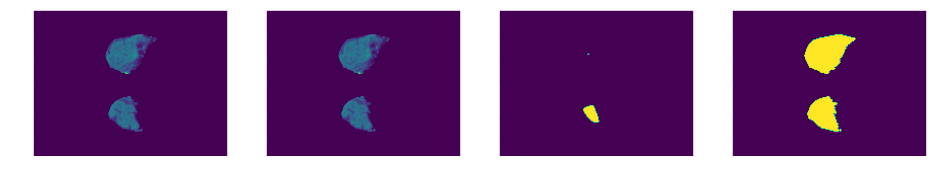

T1, T1, Prediction, Verite Terrain


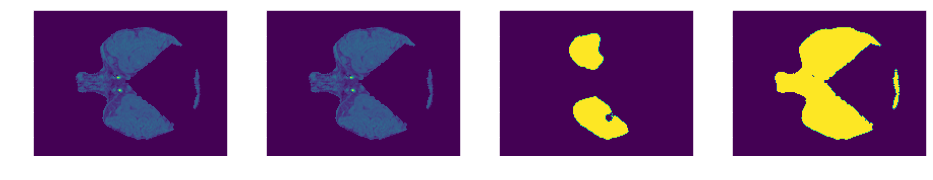

T1, T1, Prediction, Verite Terrain


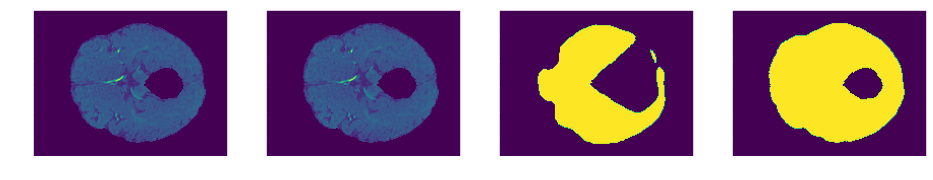

T1, T1, Prediction, Verite Terrain


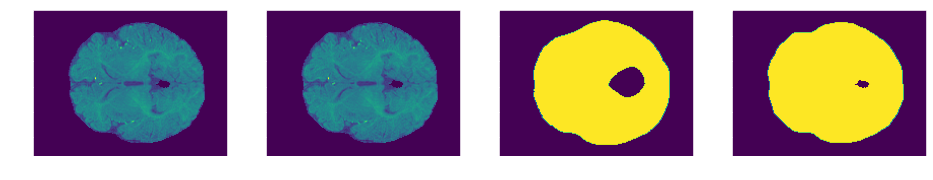

T1, T1, Prediction, Verite Terrain


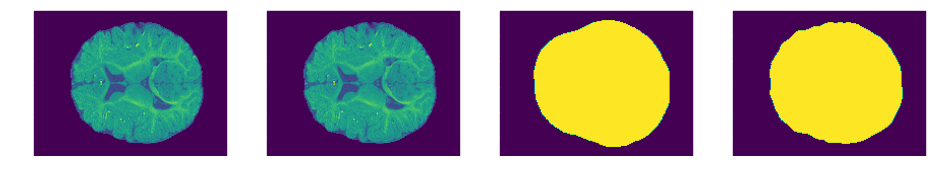

T1, T1, Prediction, Verite Terrain


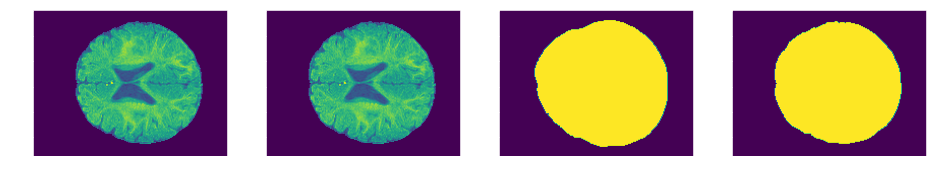

T1, T1, Prediction, Verite Terrain


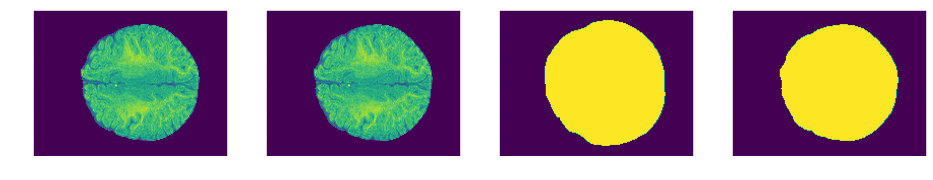

T1, T1, Prediction, Verite Terrain


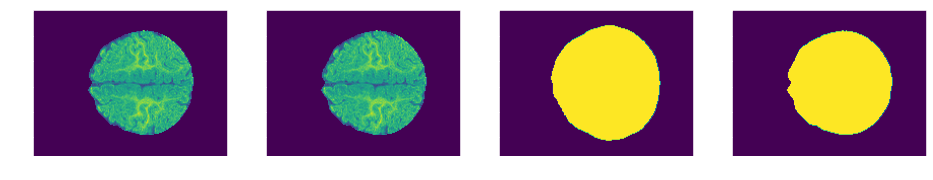

T1, T1, Prediction, Verite Terrain


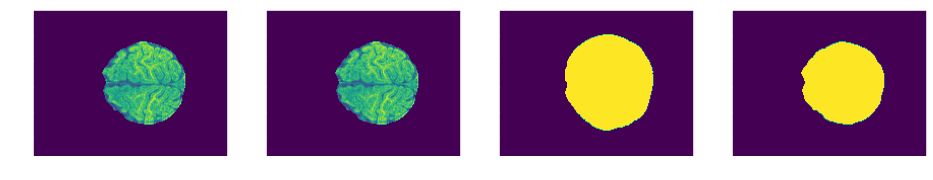

T1, T1, Prediction, Verite Terrain


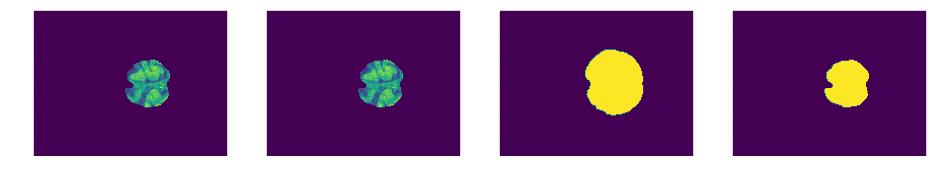

CardIntersec = 714966
CardX = 781582
CardY = 810594
Dice = 0.8980992051130026
PATIENT (test): subject-2-label.img
T1, T1, Prediction, Verite Terrain


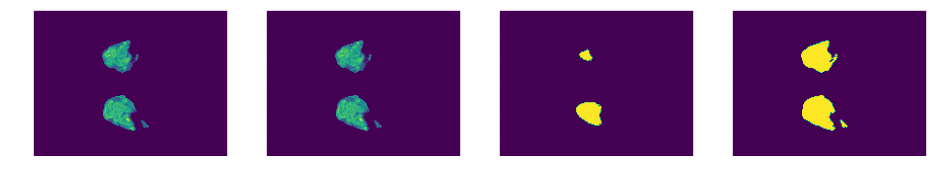

T1, T1, Prediction, Verite Terrain


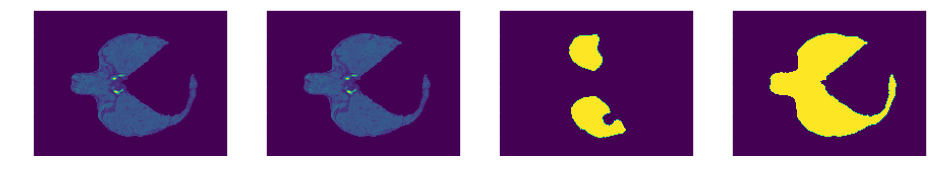

T1, T1, Prediction, Verite Terrain


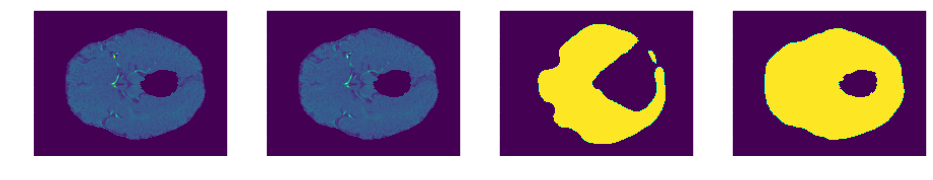

T1, T1, Prediction, Verite Terrain


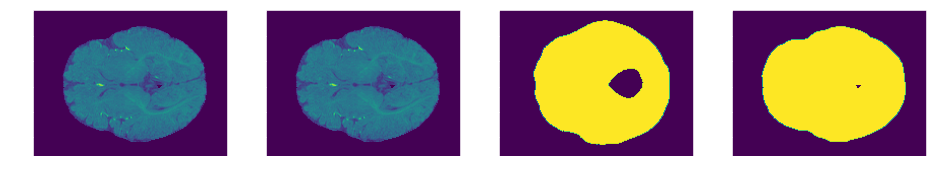

T1, T1, Prediction, Verite Terrain


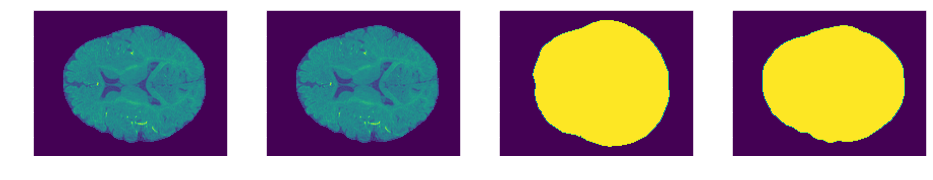

T1, T1, Prediction, Verite Terrain


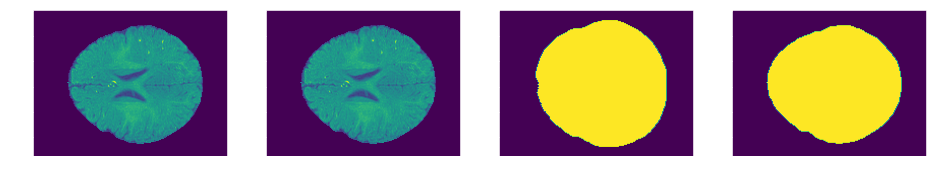

T1, T1, Prediction, Verite Terrain


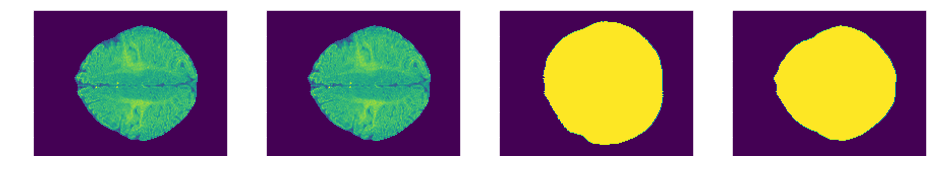

T1, T1, Prediction, Verite Terrain


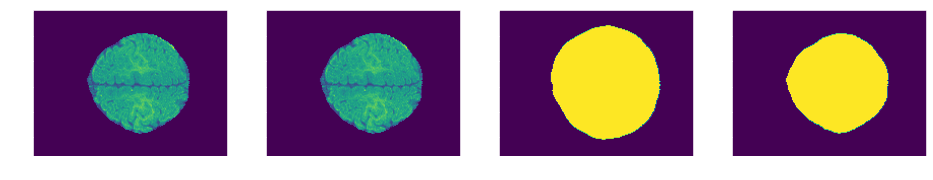

T1, T1, Prediction, Verite Terrain


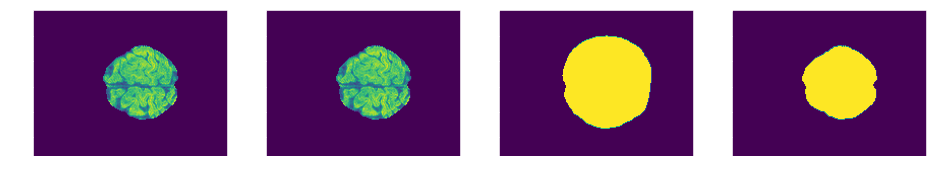

T1, T1, Prediction, Verite Terrain


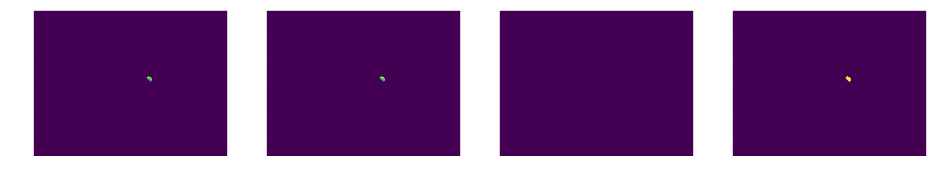

CardIntersec = 665941
CardX = 761263
CardY = 762015
Dice = 0.8743525475980091
PATIENT (test): subject-1-label.img
T1, T1, Prediction, Verite Terrain


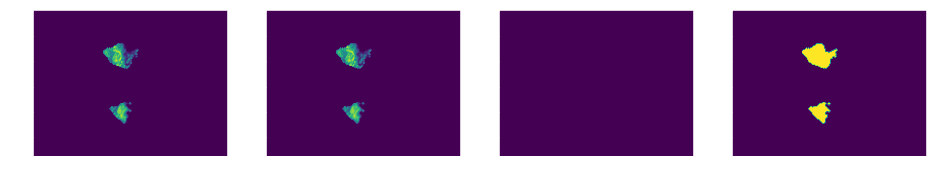

T1, T1, Prediction, Verite Terrain


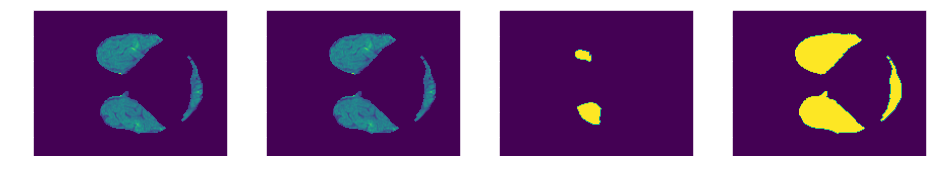

T1, T1, Prediction, Verite Terrain


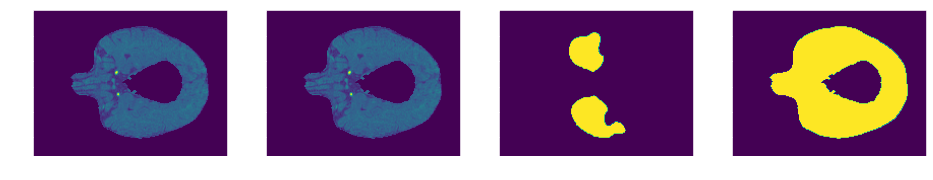

T1, T1, Prediction, Verite Terrain


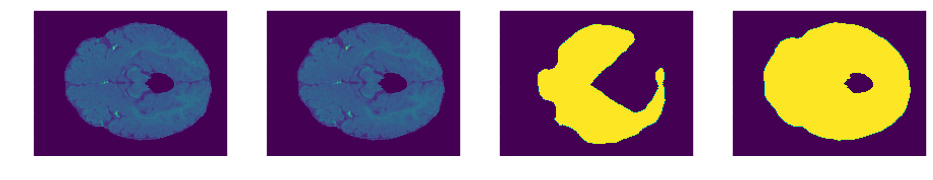

T1, T1, Prediction, Verite Terrain


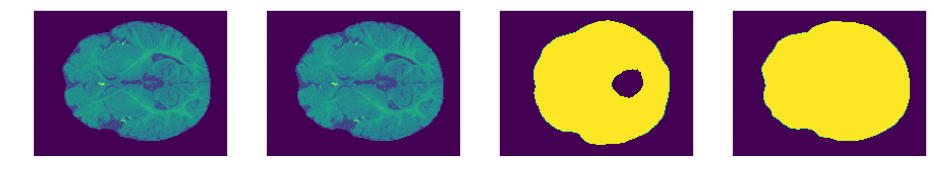

T1, T1, Prediction, Verite Terrain


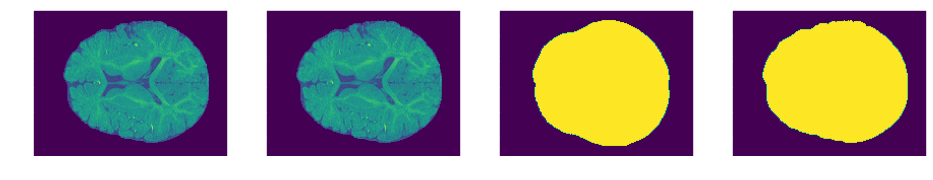

T1, T1, Prediction, Verite Terrain


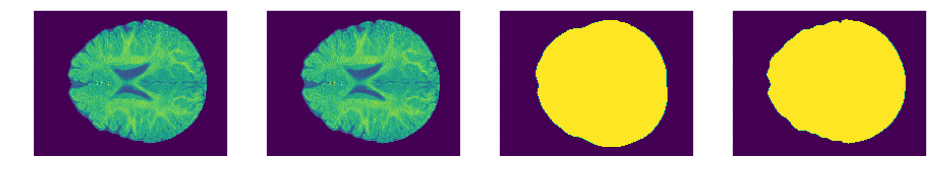

T1, T1, Prediction, Verite Terrain


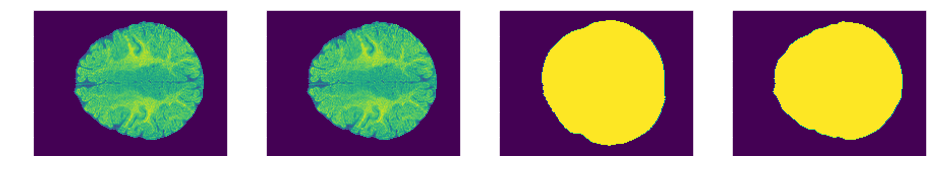

T1, T1, Prediction, Verite Terrain


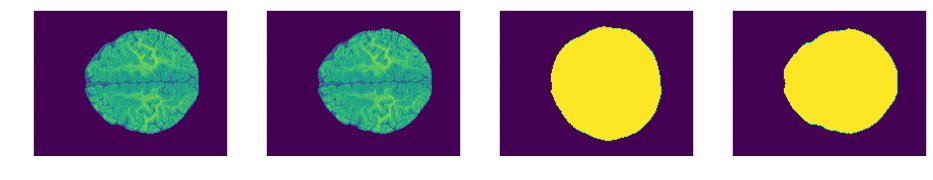

T1, T1, Prediction, Verite Terrain


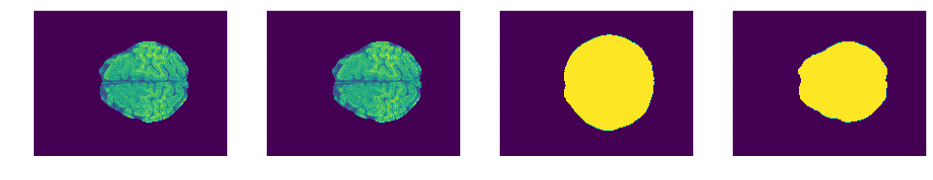

T1, T1, Prediction, Verite Terrain


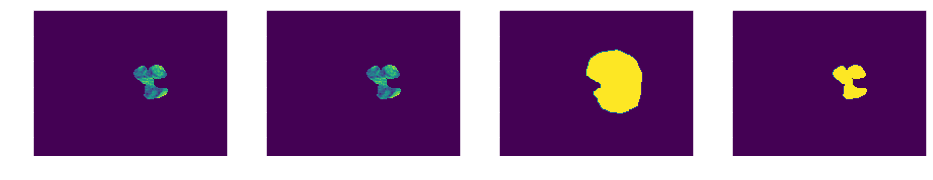

CardIntersec = 732502
CardX = 783030
CardY = 921422
Dice = 0.8595161377381118


IndexError: index 2 is out of bounds for axis 0 with size 2

In [22]:
nb_patient = 0
new_nb_patient_test = 0

for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if "label" in filename and "hdr" not in filename:
            if nb_patient <= nb_patient_training + nb_patient_validation and nb_patient < nb_patient_training:
                print("PATIENT (test):", filename)
                T1_name = filename[:-10] + "-T1.img"
                T1 = nib.load(T1_name).get_fdata()
                T2_name = filename[:-10] + "-T2.img"
                T2 = nib.load(T2_name).get_fdata()
                labels = nib.load(filename).get_fdata()
                
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                
                prediction3D_10 = np.zeros((sx, sy, sz))
                
                T1_normalized = Normalisation(T1).reshape((sx, sy, sz))
                T2_normalized = Normalisation(T2).reshape((sx, sy, sz))
                VT10 = np.where(labels >= 10, 1, 0)
                
                for z in range(0, sz):
                    input_network = np.zeros((1, sx, sy, 2))
                    input_network[0, :, :, 0] = T1_normalized[:, :, z]
                    input_network[0, :, :, 1] = T1_normalized[:, :, z]
                    prediction10 = np.round(model_step1.predict(input_network, verbose=0).reshape((sx, sy)))
                    prediction3D_10[:, :, z] = np.copy(prediction10)
                    
                    prediction_to_plot = np.copy(prediction10)
                    VT_to_plot = np.copy(VT10[:, :, z])
                    if z % 10 == 0 and np.sum(VT_to_plot) > 0:
                        VT_to_plot[0, 0] = 1.0
                        prediction_to_plot[0, 0] = 1.0
                        print("T1, T1, Prediction, Verite Terrain")
                        fast_display(T1_normalized[:, :, z].reshape((sx, sy)), T1_normalized[:, :, z].reshape((sx, sy)), prediction_to_plot, VT_to_plot)
                dice = ComputeDice(prediction3D_10, VT10)
                list_dice_crane[new_nb_patient_test] = dice
                new_nb_patient_test += 1 
            nb_patient += 1